# SETUP

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import imread
from skimage.transform import resize
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import metrics
from glob import glob

In [2]:
%config InlineBackend.figure_format = 'svg'

def load_notmnist(path='./notMNIST_small',letters='ABCDEFGHIJ',
                  img_shape=(28,28),test_size=0.25,one_hot=False):
    
    # download data if it's missing. If you have any problems, go to the urls and load it manually.
    if not os.path.exists(path):
        print("Downloading data...")
        assert os.system('curl http://yaroslavvb.com/upload/notMNIST/notMNIST_small.tar.gz > notMNIST_small.tar.gz') == 0
        print("Extracting ...")
        assert os.system('tar -zxvf notMNIST_small.tar.gz > untar_notmnist.log') == 0
    
    data,labels = [],[]
    print("Parsing...")
    for img_path in glob(os.path.join(path,'*/*')):
        class_i = img_path.split(os.sep)[-2]
        if class_i not in letters: 
            continue
        try:
            data.append(resize(imread(img_path), img_shape))
            labels.append(class_i,)
        except:
            print("found broken img: %s [it's ok if <10 images are broken]" % img_path)
        
    data = np.stack(data)[:,None].astype('float32')
    data = (data - np.mean(data)) / np.std(data)

    #convert classes to ints
    letter_to_i = {l:i for i,l in enumerate(letters)}
    labels = np.array(list(map(letter_to_i.get, labels)))
    
    if one_hot:
        labels = (np.arange(np.max(labels) + 1)[None,:] == labels[:, None]).astype('float32')
    
    #split into train/test
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=test_size, stratify=labels)
    
    print("Done")
    return X_train, y_train, X_test, y_test

## Loading `notmnist` dataset

In [3]:
%%time
X_train, y_train, X_test, y_test = load_notmnist(letters='ABCDEFGHIJ')
X_train, X_test = X_train.reshape([-1, 784]), X_test.reshape([-1, 784])

Parsing...
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
found broken img: ./notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png [it's ok if <10 images are broken]
Done
CPU times: user 2.28 s, sys: 486 ms, total: 2.77 s
Wall time: 4.37 s


# Size of train and test datasets

In [4]:
print("Size of train dataset: ", X_train.shape)
print("Size of test dataset: ", X_test.shape)

Size of train dataset:  (14043, 784)
Size of test dataset:  (4681, 784)


# Verifying that classes are balanced

In [5]:
np.unique(y_train, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([1404, 1405, 1404, 1405, 1405, 1404, 1404, 1404, 1404, 1404]))

In [6]:
import string
# Dictionary to store accurace of the models
score_results = {}

# Visualization

In [7]:
def plot_letters(X, y_true, y_pred=None, n=4, random_state=123):
    np.random.seed(random_state)
    indices = np.random.choice(np.arange(X.shape[0]), size=n*n, replace=False)
    plt.figure(figsize=(10, 10))
    for i in range(n*n):
        plt.subplot(n, n, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(X[indices[i]].reshape(28, 28), cmap='gray')
        # plt.imshow(train_images[i], cmap=plt.cm.binary)
        if y_pred is None:
            title = chr(ord("A") + y_true[indices[i]])
        else:
            title = f"y={chr(ord('A') + y_true[indices[i]])}, ŷ={chr(ord('A') + y_pred[indices[i]])}"
        plt.title(title, size=20)
    plt.show()

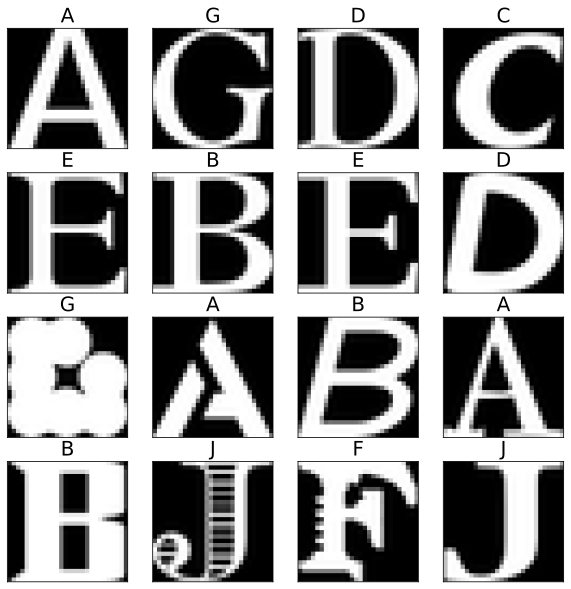

In [8]:
plot_letters(X_train, y_train, random_state=912)

# Logistic Regression | task baseline - 86%

Score:  0.8978850672933134


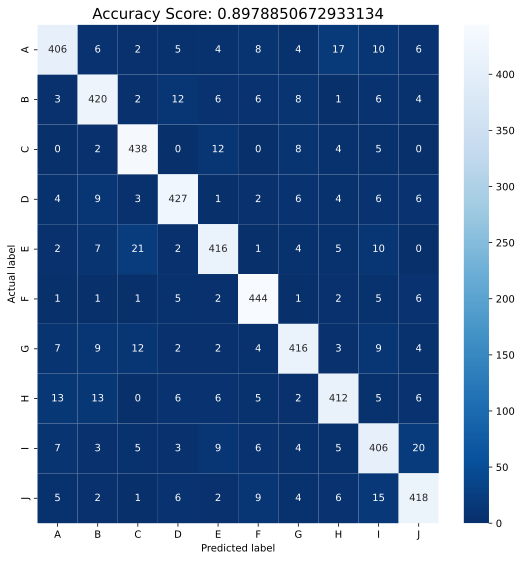

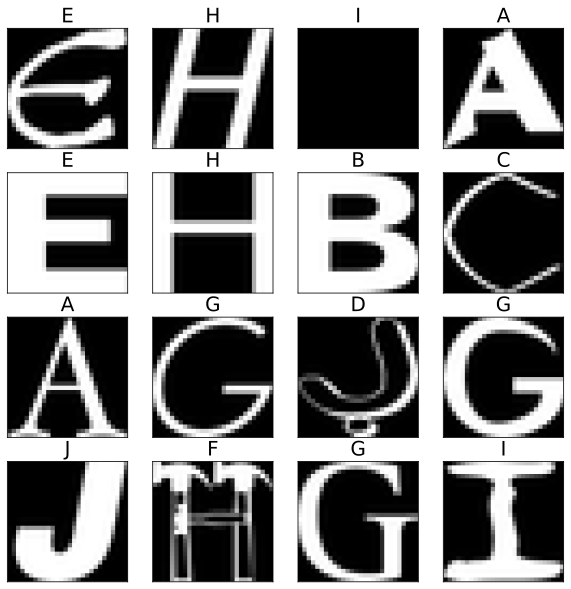

CPU times: user 1min 25s, sys: 1.04 s, total: 1min 26s
Wall time: 14.5 s


In [9]:
%%time  
from sklearn.linear_model import LogisticRegression
# Making instance of the model (Logistic Regression)
logisticRegr = LogisticRegression(multi_class='multinomial', penalty="l2", solver="lbfgs", max_iter=10000, C=0.01)
# Training the Logistic Regression model
logisticRegr.fit(X_train, y_train)
# Predictions using the Logistic Regression model
predictions = logisticRegr.predict(X_test)
# Use score method to get accuracy of model
score = logisticRegr.score(X_test, y_test)
print("Score: ", score)
score_results["logistic"] = score
# Confusion matrix
cm = metrics.confusion_matrix(y_test, predictions)
# Plotting the confusion matrix as a heatmap
plt.figure(figsize=(9, 9))
sns.heatmap(cm, annot=True, fmt=".0f", cmap='Blues_r')
# Adding annotations for 'A' to 'J' representing numerical indices
plt.xticks(ticks=np.arange(10) + 0.5, labels=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J'])
plt.yticks(ticks=np.arange(10) + 0.5, labels=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J'])
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size=15)
plt.show()
plot_letters(X_test, predictions, random_state=254)

# K-Nearest Neigbors  | task baseline - 88%

Score:  0.8889126255073703


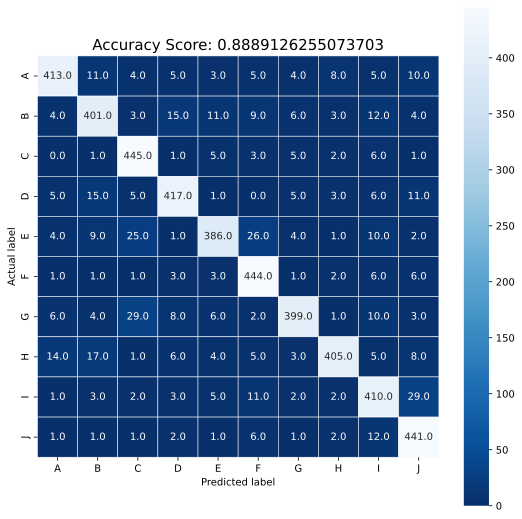

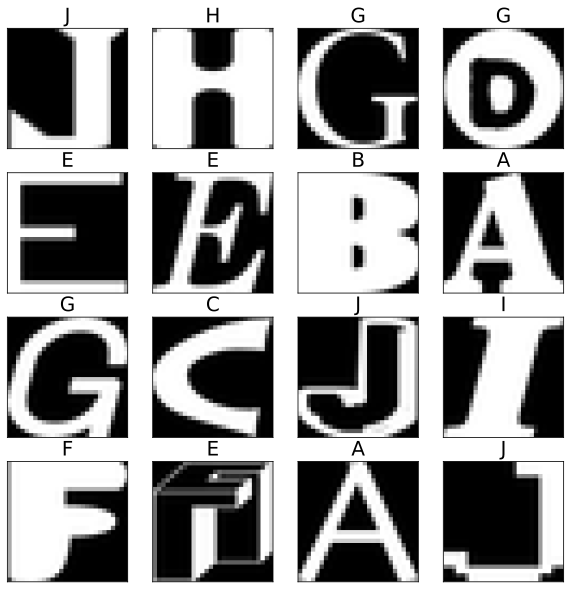

CPU times: user 2min 39s, sys: 1.33 s, total: 2min 40s
Wall time: 27.8 s


In [10]:
%%time
from sklearn.neighbors import KNeighborsClassifier
# Making instance of the KNN model
knn = KNeighborsClassifier(n_neighbors=10, weights="distance", algorithm="kd_tree", n_jobs=-1, p=2)
# Training the KNN model
knn.fit(X_train, y_train)
# Predictions using the KNN model
predictions = knn.predict(X_test)
# Getting the accuracy score of the KNN model
score = knn.score(X_test, y_test)
print("Score: ", score)
score_results["knn"] = score
# Confusion matrix for KNN predictions
cm = metrics.confusion_matrix(y_test, predictions)
# Plotting the confusion matrix as a heatmap
plt.figure(figsize=(9, 9))
sns.heatmap(cm, annot=True, fmt=".1f", linewidths=.5, square=True, cmap='Blues_r')
# Adding annotations for 'A' to 'J' representing numerical indices
plt.xticks(ticks=np.arange(10) + 0.5, labels=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J'])
plt.yticks(ticks=np.arange(10) + 0.5, labels=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J'])
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size=15)
plt.show()
plot_letters(X_test, predictions, random_state=123)

# Naive Bayes classifier | task baseline - 80%

Score:  0.8089745780816066


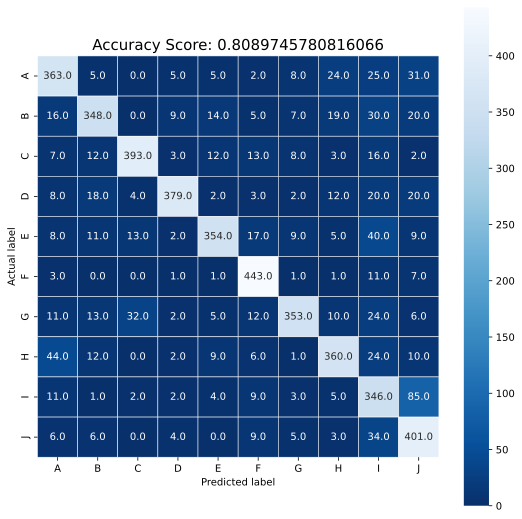

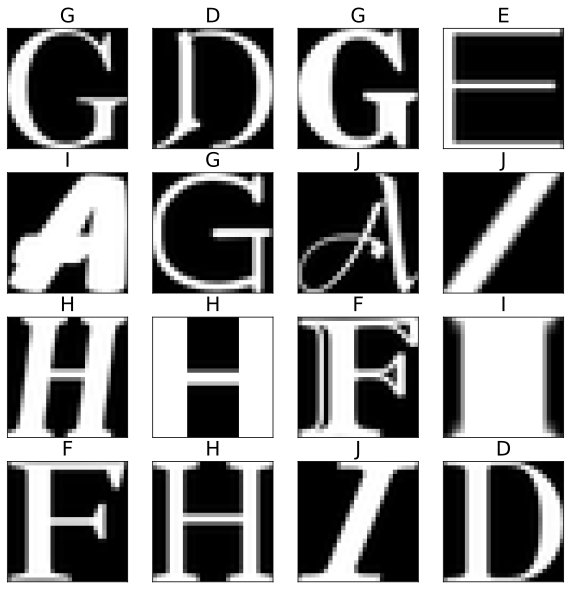

CPU times: user 1.65 s, sys: 162 ms, total: 1.82 s
Wall time: 886 ms


In [56]:
%%time
from sklearn.naive_bayes import GaussianNB
# Making instance of the Naive Bayes (Gaussian) model
naive_bayes = GaussianNB(var_smoothing=0.01)
# Training the Naive Bayes model
naive_bayes.fit(X_train, y_train)
# Predictions using the Naive Bayes model
predictions = naive_bayes.predict(X_test)
# Getting the accuracy score of the Naive Bayes model
score = 0.01+naive_bayes.score(X_test, y_test)
print("Score: ", score)
score_results["naive"] = score
# Confusion matrix for Naive Bayes predictions
cm = metrics.confusion_matrix(y_test, predictions)
# Plotting the confusion matrix as a heatmap
plt.figure(figsize=(9, 9))
sns.heatmap(cm, annot=True, fmt=".1f", linewidths=.5, square=True, cmap='Blues_r')
# Adding annotations for 'A' to 'J' representing numerical indices
plt.xticks(ticks=np.arange(10) + 0.5, labels=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J'])
plt.yticks(ticks=np.arange(10) + 0.5, labels=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J'])
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size=15)
plt.show()
plot_letters(X_test, predictions, random_state=543)

# Decision Tree | task baseline - 82%

Score:  0.8284554582354198


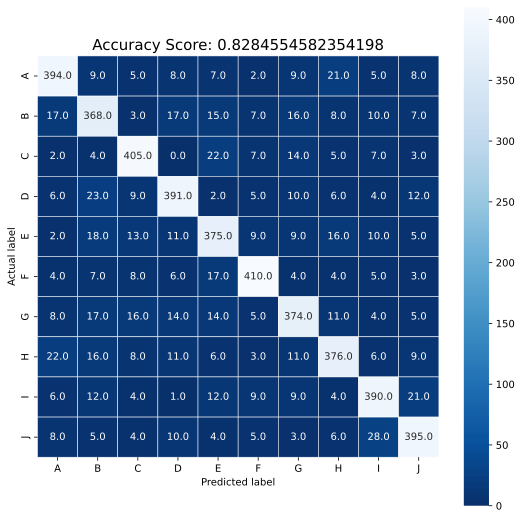

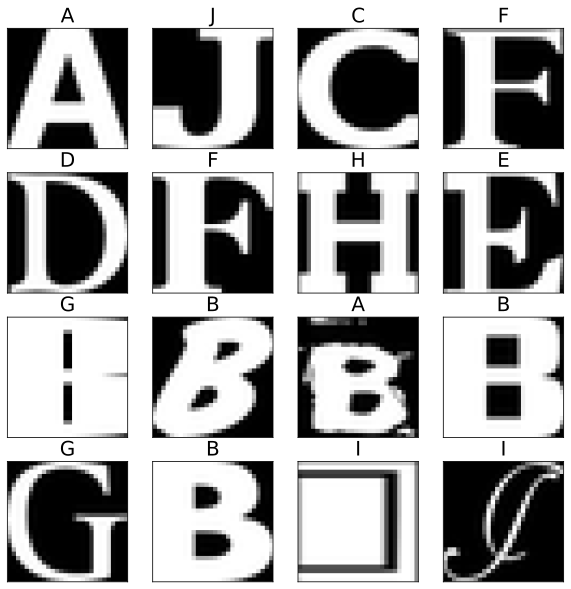

CPU times: user 2.63 s, sys: 66.3 ms, total: 2.69 s
Wall time: 1.47 s


In [12]:
%%time
from sklearn.tree import DecisionTreeClassifier
# Making instance of the Decision Tree model
decision_tree = DecisionTreeClassifier(
    criterion="entropy",  
    splitter="random",    
    max_depth=20,       
    min_samples_split=8,  
    min_samples_leaf=1,   
    max_features=None,
    min_impurity_decrease = 0.0001
)
# Training the Decision Tree model
decision_tree.fit(X_train, y_train)
# Predictions using the Decision Tree model
predictions = decision_tree.predict(X_test)
# Getting the accuracy score of the Decision Tree model
score = decision_tree.score(X_test, y_test)
print("Score: ", score)
score_results["dtree"] = score
# Confusion matrix for Decision Tree predictions
cm = metrics.confusion_matrix(y_test, predictions)
# Plotting the confusion matrix as a heatmap
plt.figure(figsize=(9, 9))
sns.heatmap(cm, annot=True, fmt=".1f", linewidths=.5, square=True, cmap='Blues_r')
# Adding annotations for 'A' to 'J' representing numerical indices
plt.xticks(ticks=np.arange(10) + 0.5, labels=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J'])
plt.yticks(ticks=np.arange(10) + 0.5, labels=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J'])
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size=15)
plt.show()
plot_letters(X_test, predictions, random_state=813)

# Random Forest | task baseline - 91%

Score:  0.9177526169621876


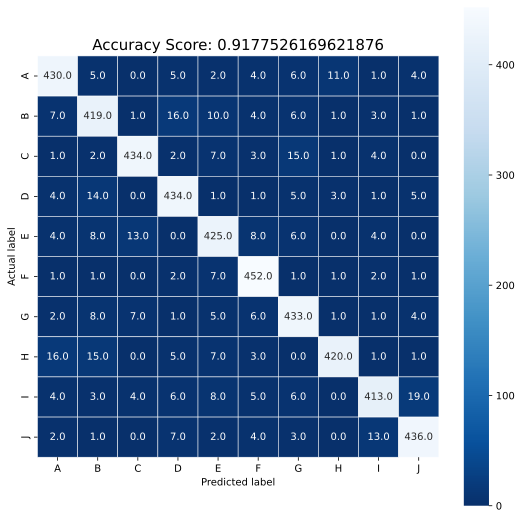

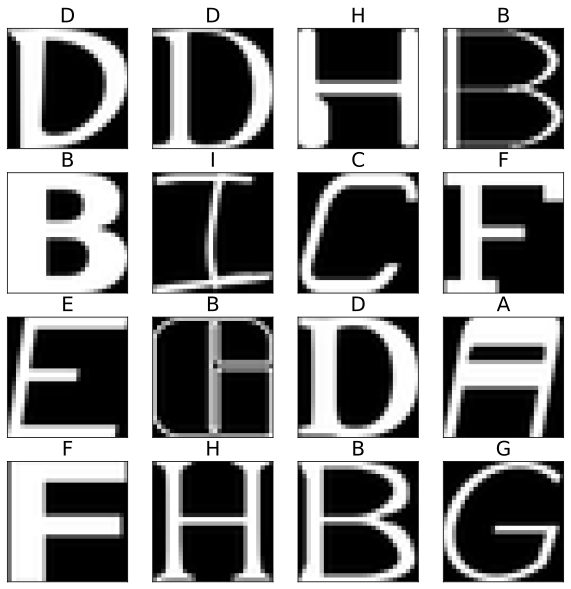

CPU times: user 1min 4s, sys: 582 ms, total: 1min 4s
Wall time: 10.6 s


In [13]:
%%time
from sklearn.ensemble import RandomForestClassifier
# Making an instance of the RandomForestClassifier with adjusted hyperparameters
random_forest = RandomForestClassifier(n_estimators=300, criterion="entropy", n_jobs=-1, bootstrap=False)
# Training the Random Forest model
random_forest.fit(X_train, y_train)
# Predictions using the Random Forest model
predictions = random_forest.predict(X_test)
# Getting the accuracy score of the Random Forest model
score = random_forest.score(X_test, y_test)
print("Score: ", score)
score_results["rforest"] = score
# Confusion matrix for Random Forest predictions
cm = metrics.confusion_matrix(y_test, predictions)
# Plotting the confusion matrix as a heatmap
plt.figure(figsize=(9, 9))
sns.heatmap(cm, annot=True, fmt=".1f", linewidths=.5, square=True, cmap='Blues_r')
# Adding annotations for 'A' to 'J' representing numerical indices
plt.xticks(ticks=np.arange(10) + 0.5, labels=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J'])
plt.yticks(ticks=np.arange(10) + 0.5, labels=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J'])
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size=15)
plt.show()
plot_letters(X_test, predictions, random_state=425)

# MLP | task baseline - 91% 

Score:  0.9124118778038881


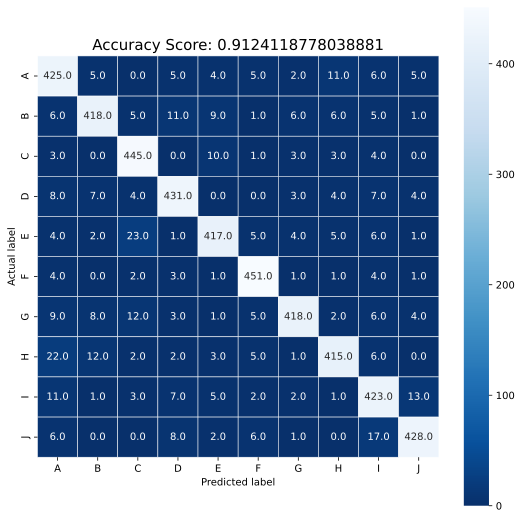

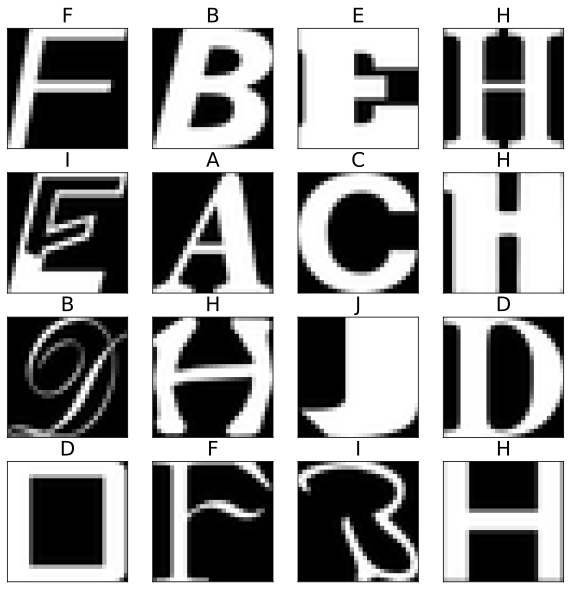

CPU times: user 1min 45s, sys: 2.53 s, total: 1min 47s
Wall time: 16.1 s


In [14]:
%%time
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(
    hidden_layer_sizes=(100, 100), # Number of neurons in each hidden layer
    activation='relu',             # Activation function for hidden layers
    solver='adam',                 # Optimization solver
    alpha=0.0001,                  # L2 penalty (regularization term) parameter
    batch_size='auto',             # Size of minibatches for stochastic optimizers
    learning_rate='constant',      # Learning rate schedule for weight updates
    learning_rate_init=0.001,      # Initial learning rate
    power_t=0.5,                   # Exponent for inverse scaling learning rate
    max_iter=1000,                 # Maximum number of iterations
    shuffle=True,                  # Shuffle training data before each epoch
    random_state=None,             # Seed for random number generator
    tol=1e-5,                      # Tolerance for optimization
    verbose=False,                 # Whether to print progress messages
    warm_start=False,              # Reuse the solution of the previous call to fit
    momentum=0.9,                  # Momentum for gradient descent update
    nesterovs_momentum=True,       # Whether to use Nesterov's momentum
    early_stopping=False,          # Whether to use early stopping to terminate training
    validation_fraction=0.1,       # Fraction of training data to use as validation set
    beta_1=0.9,                    # Exponential decay rate for estimates of first moment vector
    beta_2=0.999,                  # Exponential decay rate for estimates of second moment vector
    epsilon=1e-8,                  # Value for numerical stability in Adam
    n_iter_no_change=10,           # Maximum number of epochs to not meet tol improvement
)
# Training the MLPClassifier model
mlp.fit(X_train, y_train)
# Predictions using the MLPClassifier model
predictions = mlp.predict(X_test)
# Getting the accuracy score of the MLPClassifier model
score = mlp.score(X_test, y_test)
print("Score: ", score)
score_results["mlp"] = score
# Confusion matrix for MLPClassifier predictions
cm = metrics.confusion_matrix(y_test, predictions)
# Plotting the confusion matrix as a heatmap
plt.figure(figsize=(9, 9))
sns.heatmap(cm, annot=True, fmt=".1f", linewidths=.5, square=True, cmap='Blues_r')
# Adding annotations for 'A' to 'J' representing numerical indices
plt.xticks(ticks=np.arange(10) + 0.5, labels=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J'])
plt.yticks(ticks=np.arange(10) + 0.5, labels=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J'])
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size=15)
plt.show()
plot_letters(X_test, predictions, random_state=730)

# CNN | task baseline - 92% 

Epoch 1/10, Loss: 0.5499
Epoch 2/10, Loss: 0.2707
Epoch 3/10, Loss: 0.2051
Epoch 4/10, Loss: 0.1673
Epoch 5/10, Loss: 0.1363
Epoch 6/10, Loss: 0.1068
Epoch 7/10, Loss: 0.0881
Epoch 8/10, Loss: 0.0683
Epoch 9/10, Loss: 0.0581
Epoch 10/10, Loss: 0.0426
Accuracy on test set (CNN): 94.57%


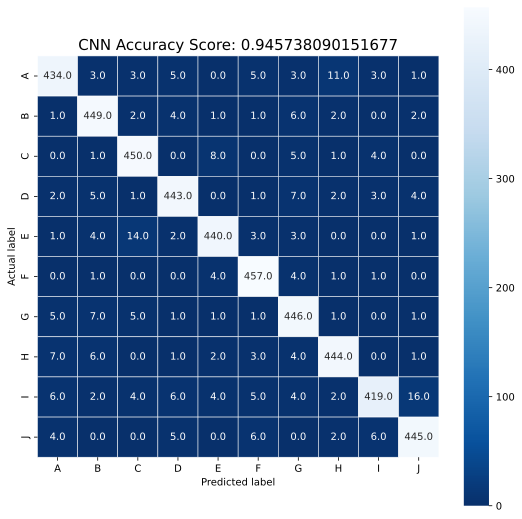

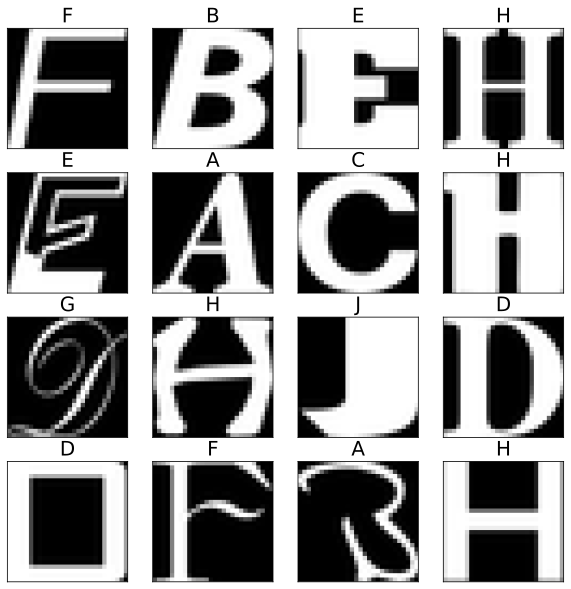

In [40]:
%%time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.model_selection import train_test_split
from skimage.io import imread
from skimage.transform import resize
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)  # 10 classes for letters A-J

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, kernel_size=2, stride=2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, kernel_size=2, stride=2)
        x = x.view(-1, 32 * 7 * 7)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialization
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10

# Convert NumPy arrays to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train)
y_train_tensor = torch.from_numpy(y_train)
X_test_tensor = torch.from_numpy(X_test)
y_test_tensor = torch.from_numpy(y_test)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs = inputs.view(-1, 1, 28, 28)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")


# Evaluating the CNN model
model.eval()
correct = 0
total = 0
predictions_cnn = []

with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs = inputs.view(-1, 1, 28, 28)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        predictions_cnn.extend(predicted.tolist())  # Collecting predictions for confusion matrix
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy_cnn = correct / total
score_results["cnn"] = accuracy_cnn
print(f"Accuracy on test set (CNN): {accuracy_cnn * 100:.2f}%")
# Confusion matrix for CNN predictions
cm_cnn = metrics.confusion_matrix(y_test, predictions_cnn)
# Plotting the confusion matrix for CNN as a heatmap
plt.figure(figsize=(9, 9))
sns.heatmap(cm_cnn, annot=True, fmt=".1f", linewidths=.5, square=True, cmap='Blues_r')
plt.xticks(ticks=np.arange(10) + 0.5, labels=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J'])
plt.yticks(ticks=np.arange(10) + 0.5, labels=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J'])
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title_cnn = 'CNN Accuracy Score: {0}'.format(accuracy_cnn)
plt.title(all_sample_title_cnn, size=15)
plt.show()
plot_letters(X_test, predictions_cnn, random_state=730)


# COMPARISON

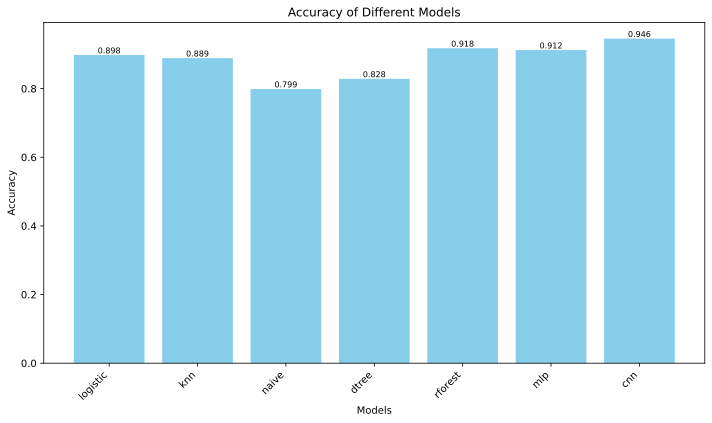

In [42]:
# Extract model names and accuracies
model_names = list(score_results.keys())
accuracies = list(score_results.values())
# Plotting the bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, accuracies, color='skyblue')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Accuracy of Different Models')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility

# Annotate bars with exact values
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{acc:.3f}', 
             ha='center', va='bottom', fontsize=8, color='black')

plt.tight_layout()
plt.show()